In [1]:
#dense optical flow
#https://docs.opencv.org/2.4/modules/video/doc/motion_analysis_and_object_tracking.html

import cv2
import numpy as np

def display_flow(img, flow, stride=10):
    for index in np.ndindex(flow[::stride, ::stride].shape[:2]): #(0,0), (0,10), (10,10), .......
        pt1 = tuple(i*stride for i in index)
        delta = flow[pt1].astype(np.int32)[::-1]
        pt2 = tuple(pt1 + 2*delta)
        if 2 <= cv2.norm(delta) <= 10:
            cv2.arrowedLine(img, pt1[::-1], pt2[::-1], (0,0,255), 1, cv2.LINE_AA, 0, 0.1)
    norm_opt_flow = np.linalg.norm(flow, axis=2)
    norm_opt_flow = cv2.normalize(norm_opt_flow, None, 0, 1, cv2.NORM_MINMAX)
    cv2.imshow('optical flow', img)
    cv2.imshow('optical flow magnitude', norm_opt_flow)
    k = cv2.waitKey(1)
    if k == 27:
        return 1
    else:
        return 0
                            
cap = cv2.VideoCapture("wiiplay.mp4")
frame_seq = 3100
cap.set(cv2.CAP_PROP_POS_FRAMES , frame_seq)
_ , prev_frame = cap.read()
prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_frame = cv2.resize(prev_frame, (0,0), None, 0.5, 0.5)
first_frame = True

while True:
    status_cap, frame = cap.read()
    frame = cv2.resize(frame, (0,0), None, 0.5, 0.5)
    if not status_cap:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #use cv2.calcOpticalFlowPyrLK() for sparse optical flow
    if first_frame:
        opt_flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, None, 0.5, 5, 13, 10, 5, 1.1, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        first_frame = False
    else:
        opt_flow = cv2.calcOpticalFlowFarneback(prev_frame, gray, opt_flow, 0.5, 5, 13, 10, 5, 1.1, cv2.OPTFLOW_USE_INITIAL_FLOW)
    prev_frame = np.copy(gray)
    if display_flow(frame, opt_flow):
        break;
cv2.destroyAllWindows()                            

In [2]:
#CamShift
#not covered in class
#https://docs.opencv.org/3.4/d7/d00/tutorial_meanshift.html

import sys
import cv2
import numpy as np
class ObjectTracker():
    def __init__(self):
        # Initialize the video capture object
        # 0 -> indicates that frame should be captured
        # from webcam
        self.cap = cv2.VideoCapture(0)
        # Capture the frame from the webcam
        ret, self.frame = self.cap.read()
        # Downsampling factor for the input frame
        self.scaling_factor = 0.8
        self.frame = cv2.resize(self.frame, None, fx=self.scaling_factor, fy=self.scaling_factor)
        cv2.namedWindow('Object Tracker')
        cv2.setMouseCallback('Object Tracker', self.mouse_event)
        self.selection = None
        self.drag_start = None
        self.tracking_state = 0
    # Method to track mouse events
    def mouse_event(self, event, x, y, flags, param):
        x, y = np.int16([x, y])
        # Detecting the mouse button down event
        if event == cv2.EVENT_LBUTTONDOWN:
            self.drag_start = (x, y)
            self.tracking_state = 0
        if self.drag_start:
            if event == cv2.EVENT_MOUSEMOVE:
                h, w = self.frame.shape[:2]
                xo, yo = self.drag_start
                x0, y0 = np.maximum(0, np.minimum([xo, yo], [x, y]))
                x1, y1 = np.minimum([w, h], np.maximum([xo, yo], [x, y]))
                self.selection = None
                if x1-x0 > 0 and y1-y0 > 0:
                    self.selection = (x0, y0, x1, y1)
            elif event == cv2.EVENT_LBUTTONUP:
                self.drag_start = None
                if self.selection is not None:
                    self.tracking_state = 1
    # Method to start tracking the object
    def start_tracking(self):
        # Iterate until the user presses the Esc key
        while True:
            # Capture the frame from webcam
            ret, self.frame = self.cap.read()
            # Resize the input frame
            self.frame = cv2.resize(self.frame, None, fx=self.scaling_factor, fy=self.scaling_factor)
            vis = self.frame.copy()
            # Convert to HSV color space
            hsv = cv2.cvtColor(self.frame, cv2.COLOR_BGR2HSV)
                                    # Create the mask based on predefined thresholds.
            mask = cv2.inRange(hsv, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
            if self.selection:
                x0, y0, x1, y1 = self.selection
                self.track_window = (x0, y0, x1-x0, y1-y0)
                hsv_roi = hsv[y0:y1, x0:x1]
                mask_roi = mask[y0:y1, x0:x1]
                # Compute the histogram
                hist = cv2.calcHist( [hsv_roi], [0], mask_roi, [16], [0, 180] )
                # Normalize and reshape the histogram
                cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX);
                self.hist = hist.reshape(-1)
                vis_roi = vis[y0:y1, x0:x1]
                cv2.bitwise_not(vis_roi, vis_roi)
                vis[mask == 0] = 0
            if self.tracking_state == 1:
                self.selection = None
                # Compute the histogram back projection
                prob = cv2.calcBackProject([hsv], [0], self.hist, [0, 180], 1)
                prob &= mask
                term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
                # Apply CAMShift on 'prob'
                track_box, self.track_window = cv2.CamShift(prob, self.track_window, term_crit)
                                                            # Draw an ellipse around the object
                cv2.ellipse(vis, track_box, (0, 255, 0), 2)
            cv2.imshow('Object Tracker', vis)
            c = cv2.waitKey(delay=5)
            if c == 27:
                break
        self.cap.release()
        cv2.destroyAllWindows()
                                            
if __name__ == '__main__':
    ObjectTracker().start_tracking()

In [3]:
# MIL Tracker
# if you receive error : cv2 TrackerMedianFlow_create has no attribute
# conda install pip
# pip uninstall opencv-python
# pip install opencv-contrib-python --user
# change cv2.TrackerMedianFlow_create() to cv2.legacy.TrackerMedianFlow_create()
# https://stackoverflow.com/questions/58922153/opencv-attributeerror-module-cv2-cv2-has-no-attribute-tracker-create

import cv2
import numpy as np

cap = cv2.VideoCapture("wiiPlay.mp4")
frame_seq = 3100
cap.set(cv2.CAP_PROP_POS_FRAMES , frame_seq)
status_cap, frame = cap.read()
bbox = cv2.selectROI(frame, True, False)
cv2.destroyAllWindows()

tracker = cv2.TrackerMIL_create()
status_tracker = tracker.init(frame, bbox)
fps = 0

while True:
    frame_seq += 1
    if frame_seq > 3800:
        frame_seq = 3100
    cap.set(cv2.CAP_PROP_POS_FRAMES , frame_seq)
    status_cap, frame = cap.read()
    if not status_cap:
        break
    timer = cv2.getTickCount()
    status_tracker, bbox = tracker.update(frame)
    if status_tracker:
        x, y, w, h = [int(i) for i in bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 15)
        fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);
        cv2.putText(frame, "FPS: %.0f" % fps, (0, 80), cv2.FONT_HERSHEY_SIMPLEX,2,(0,0,255),5)
    else:
        cv2.putText(frame, "Tracking failure detected", (0, 80), cv2.FONT_HERSHEY_SIMPLEX,2,(0,0,255),5)
    cv2.imshow("MIL tracker", frame)
    k = cv2.waitKey(1)
    if k == 27:
        break
cv2.destroyAllWindows()

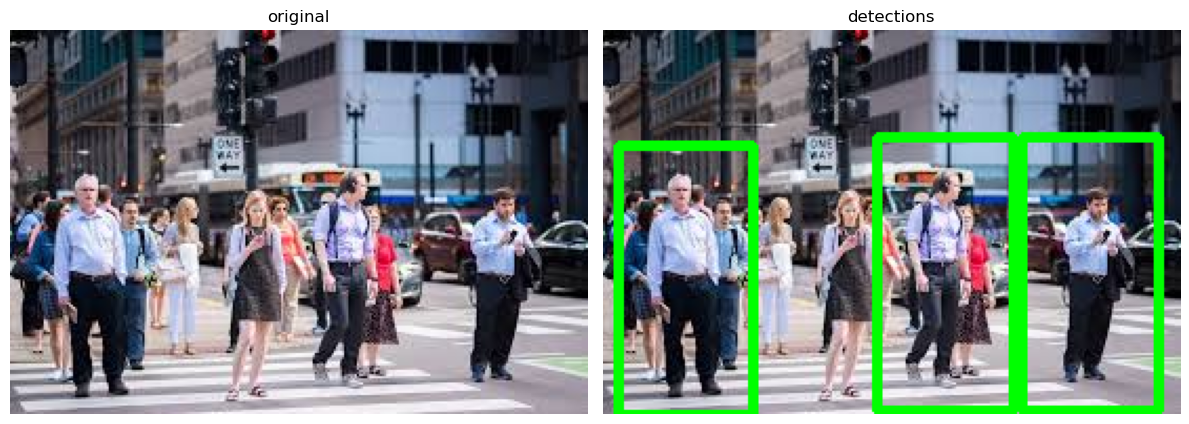

In [4]:
#pedestrian detector using SVM with HOG feature
#https://www.pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/

import cv2
import matplotlib.pyplot as plt

image = cv2.imread('pedestrian.jpg')
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
locations, weights = hog.detectMultiScale(image, hitThreshold = 0, winStride=(1,1), groupThreshold = 1.0)

dbg_image = image.copy()
for loc in locations:
    cv2.rectangle(dbg_image, (loc[0], loc[1]),(loc[0]+loc[2], loc[1]+loc[3]), (0, 255, 0), 3)
  
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('original')
plt.axis('off')
plt.imshow(image[:,:,[2,1,0]])
plt.subplot(1,2,2)
plt.title('detections')
plt.axis('off')
plt.imshow(dbg_image[:,:,[2,1,0]])
plt.tight_layout()
plt.show()

<b>img</b>	Matrix of the type CV_8U or CV_8UC3 containing an image where objects are detected.

<b>hitThreshold</b>	Threshold for the distance between features and SVM classifying plane. Usually it is 0 and should be specified in the detector coefficients (as the last free coefficient). 

<b>winStride</b>	Window stride. It must be a multiple of block stride.

<b>padding</b>	Padding

<b>scale</b>	Coefficient of the detection window increase.

<b>groupThreshold</b>	Coefficient to regulate the similarity threshold. When detected, some objects can be covered by many rectangles. 0 means not to perform grouping.

<b>useMeanshiftGrouping</b>	indicates grouping algorithm

###### %%writefile test
## Practice : Detector followed by Tracker
1. Input images from wiiplay.mp4 for level 52 (frame number:19400~20000).
2. Use <i>cv2.HOGDescriptor()</i> to <b>detect</b> pedestrian on the first frame. (frame number=19400)
3. Try to <b>track</b> the detected pedestrian on subsequent frames. (marked as <b>red</b> rectangle)
4. Instead of detection followed by tracking, try to detect pedestrian on each frames without tracking. (marked as <b>green</b> rectangle)
5. Observe the results and compare the difference between these two approaches. 
6. Show your output images.
7. Upload your Jupyter code file (*.ipynb)